In [1]:
import numpy as np

from ctdna.detection import compute_pval_th, calculate_sensitivity
from ctdna.utils import diameter_cells, cells_diameter, calculate_elimination_rate
import ctdna.settings as settings
from rll.plotting import plot_xy

In [2]:
import logging
# get logger
logger = logging.getLogger('ctdna')
logger.setLevel(logging.WARNING)

## Calculating the probability to detect a specific point mutation in ctDNA for tumors with a given size and for different specificities

In [3]:
# lung cancer
b_lung = 0.14  # cell birth rate
d_lung = 0.136  # cell death rate
q_d_lung = 1.4e-4  # shedding probability

fpr = 0.01  # false positive rate (1 - specificity)
seq_err = 1e-5  # sequencing error rate

# convert cfDNA half-life time in minutes to an elimination rate per day
t12_cfdna_mins = 30
epsilon = calculate_elimination_rate(t12_cfdna_mins)

# parameters for the gamma-distributed plasma DNA concentrations
dna_conc_gamma_params = settings.FIT_GAMMA_PARAMS

seq_eff = 0.5  # sequencing efficiency
panel_size = 1  # consider exactly one actionable mutation
n_det_muts = 1  # number of called mutations required for detection
n_muts_cancer = n_det_muts  # actionable mutation is present in the cancer cells

# translate tumor diameters [cm] into number of cells
tumor_sizes = np.array([diameter_cells(1), 1e9, diameter_cells(1.5), diameter_cells(2)])

# calculate a threshold to call a mutation such that a given false positive rate is achieved
pval_th = compute_pval_th(
    fpr, panel_size, seq_err, seq_eff, dna_conc_gamma_params, epsilon=epsilon)

# calculate the probability to detect a mutation of tumors with different sizes
det_probs = calculate_sensitivity(
    b_lung, d_lung, q_d_lung, epsilon, n_det_muts, panel_size, n_muts_cancer,
    pval_th=pval_th, dna_conc_gamma_params=dna_conc_gamma_params,
    seq_err=seq_err, seq_eff=seq_eff, tumor_sizes=tumor_sizes)

diameters = [cells_diameter(size) for size in tumor_sizes]
print('Detection probabilities for 99% specificity in tumors of sizes: '
      + ', '.join(f'{p:.1%} ({d:.1f} cm; {c:.1e})' for p, c, d in zip(det_probs, tumor_sizes, diameters)))

Detection probabilities for 99% specificity in tumors of sizes: 17.6% (1.0 cm; 5.2e+08), 33.6% (1.2 cm; 1.0e+09), 56.0% (1.5 cm; 1.8e+09), 90.7% (2.0 cm; 4.2e+09)


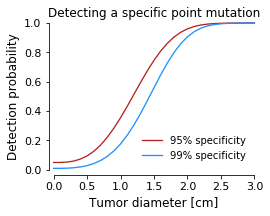

In [4]:
# array of tumor diameters
diameters = np.linspace(0.0, 3, 31)
# translate tumor diameters [cm] into number of cells
tumor_sizes = np.array([diameter_cells(d) for d in diameters])

fprs = [0.05, 0.01]
labels = []
det_probs = np.zeros((len(fprs), len(diameters)))

for i, fpr in enumerate(fprs):
    
    labels.append(f'{1.0-fpr:.0%} specificity')
    
    # calculate a threshold to call a mutation such that a given false positive rate is achieved
    pval_th = compute_pval_th(
        fpr, panel_size, seq_err, seq_eff, dna_conc_gamma_params, epsilon=epsilon)

    # calculate the probability to detect a mutation of tumors with different sizes
    det_probs[i, :] = calculate_sensitivity(
        b_lung, d_lung, q_d_lung, epsilon, n_det_muts, panel_size, n_muts_cancer,
        pval_th=pval_th, dna_conc_gamma_params=dna_conc_gamma_params,
        seq_err=seq_err, seq_eff=seq_eff, tumor_sizes=tumor_sizes)

# plot probabilities
xlim = (diameters[0], diameters[-1])
ylim = (0, 1)
xlabel = 'Tumor diameter [cm]'
ylabel = 'Detection probability'
title = 'Detecting a specific point mutation'
plot_xy(diameters, det_probs, xlim=xlim, ylim=ylim, 
        xlabel=xlabel, ylabel=ylabel, title=title, colors=['firebrick', 'dodgerblue'], 
        labels=labels, legend_loc=4,
       );